In [ ]:
locals()

In [3]:
import os
import math
import random
import datetime
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
import sys
sys.path.append('../')
sys.path.append('SSD-Tensorflow')

In [6]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [7]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [8]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ../checkpoints/ssd_300_vgg.ckpt: Not found: ../checkpoints
	 [[Node: save/RestoreV2_5 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_5/tensor_names, save/RestoreV2_5/shape_and_slices)]]

Caused by op 'save/RestoreV2_5', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b298b08ebce9>", line 20, in <module>
    saver = tf.train.Saver()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 663, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on ../checkpoints/ssd_300_vgg.ckpt: Not found: ../checkpoints
	 [[Node: save/RestoreV2_5 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_5/tensor_names, save/RestoreV2_5/shape_and_slices)]]


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


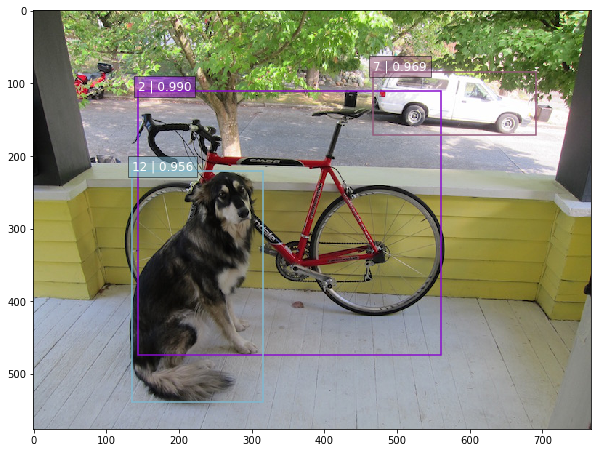

In [8]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[-5])
rclasses, rscores, rbboxes =  process_image(img)
print(type(rclasses))
print(type(rscores))
print(type(rbboxes))


# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [9]:
export_path = "/tmp/ssd_serving/{}".format(datetime.datetime.now())
print('Exporting trained model to {0}...'.format(export_path))

builder = tf.saved_model.builder.SavedModelBuilder(export_path)

tensor_info_img_input = tf.saved_model.utils.build_tensor_info(img_input)

tensor_info_image_4d = tf.saved_model.utils.build_tensor_info(image_4d)
tensor_info_predictions = [tf.saved_model.utils.build_tensor_info(x) for x in predictions]
tensor_info_localisations = [tf.saved_model.utils.build_tensor_info(x) for x in localisations]
tensor_info_bbox_img = tf.saved_model.utils.build_tensor_info(bbox_img)

outputs = {
    'image_4d': tensor_info_image_4d,
    'bbox_img': tensor_info_bbox_img
}

for x in predictions:
    outputs[x.name] = tf.saved_model.utils.build_tensor_info(x)
    
for x in localisations:
    outputs[x.name] = tf.saved_model.utils.build_tensor_info(x)

classification_signature = (
  tf.saved_model.signature_def_utils.build_signature_def(
      inputs={
          'img_input': tensor_info_img_input
      },
      outputs = outputs,
      method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)
)

legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder.add_meta_graph_and_variables(
  isess, [tf.saved_model.tag_constants.SERVING],
  signature_def_map={
      tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: classification_signature
  },
  legacy_init_op=legacy_init_op)
builder.save()
print('Export finished')

Exporting trained model to /tmp/ssd_serving/2017-10-26 11:49:49.923291...
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/tmp/ssd_serving/2017-10-26 11:49:49.923291/saved_model.pb'
Export finished


In [ ]:
[print(x) for x in predictions]
[print(x) for x in localisations]

In [12]:
import json
import urllib.request

class Hydroserving:
  """
  Hydroserving REST API wrapper.
  """
  serving_addr = "http://54.191.51.127:9090" # Hydroserving instance endpoint

  @staticmethod
  def _post_data(url, data):
    """
    Sends POST request with `data` to the given `url`
    """
    json_data = json.dumps(data)
    req = urllib.request.Request(url, json_data.encode('utf-8'), {'Content-Type': 'application/json'})
    f = urllib.request.urlopen(req)
    print(f)
    response = json.loads(f.read().decode("utf-8"))
    f.close()
    return response

  @staticmethod
  def _build_model(model_name):
    """
    Sends a request to build a model runtime for a model with `model_name` name
    """
    url = Hydroserving.serving_addr + '/api/v1/model/buildByName'
    data = {
        'modelName': model_name
      }
    return Hydroserving._post_data(url, data)

  @staticmethod
  def build_service(model_name):
    """
    Sends a request to build a model service for given model
    """
    response = Hydroserving._build_model(model_name)
    runtime_id = response['id']
    url = Hydroserving.serving_addr + '/api/v1/modelService'
    data = {
      'serviceName': '{}_{}'.format(model_name, runtime_id),
      'modelRuntimeId': runtime_id
    }
    return Hydroserving._post_data(url, data)

  @staticmethod
  def serve(model_name, data):
    """
    Sends serving request to the model service with given name.
    """
    url = Hydroserving.serving_addr + '/api/v1/modelService/serve/{}'.format(model_name)
    return Hydroserving._post_data(url, data)

In [ ]:
Hydroserving.build_service('tf_ssd')

In [ ]:
from tensorflow.python.saved_model import constants
print(constants.LEGACY_INIT_OP_KEY)

In [ ]:
with tf.Session() as sess:
    meta_graph = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_path)
    signature = meta_graph.signature_def[tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

In [9]:
data = [
    {
        "img_input": mpimg.imread(path + image_names[-5]).tolist()
    }
]

In [ ]:
def serve(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    res = Hydroserving.serve("tf_ssd2", data)
    rimg = np.array(res[0]['image_4d'])
    rpredictions = [
        np.array(res[0]['ssd_300_vgg/softmax/Reshape_1:0']),
        np.array(res[0]['ssd_300_vgg/softmax_1/Reshape_1:0']),
        np.array(res[0]['ssd_300_vgg/softmax_2/Reshape_1:0']),
        np.array(res[0]['ssd_300_vgg/softmax_3/Reshape_1:0']),
        np.array(res[0]['ssd_300_vgg/softmax_4/Reshape_1:0']),
        np.array(res[0]['ssd_300_vgg/softmax_5/Reshape_1:0'])
    ]
    rlocalisations = [
        np.array(res[0]['ssd_300_vgg/block4_box/Reshape:0']),
        np.array(res[0]['ssd_300_vgg/block7_box/Reshape:0']),
        np.array(res[0]['ssd_300_vgg/block8_box/Reshape:0']),
        np.array(res[0]['ssd_300_vgg/block9_box/Reshape:0']),
        np.array(res[0]['ssd_300_vgg/block10_box/Reshape:0']),
        np.array(res[0]['ssd_300_vgg/block11_box/Reshape:0'])
    ]
    rbbox_img = res[0]['bbox_img']
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    print(rbbox_img)   
    print(len(rbboxes))

    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [ ]:
rrclasses, rrscores, rrbboxes = serve(data)
visualization.plt_bboxes(mpimg.imread(path + image_names[-5]), rrclasses, rrscores, rrbboxes)

In [13]:
def serve_postproc(data):
    # Run SSD network.
    res = Hydroserving.serve("tf_ssd2", data)

    return res

In [16]:
res = serve_postproc(data)
first_res = res[0]

print(first_res['classes'])
print(first_res['scores'])
print(first_res['boxes'])

visualization.plt_bboxes(
    mpimg.imread(path + image_names[-5]),
    np.array(first_res['classes']),
    np.array(first_res['scores']), 
    np.array(first_res['boxes'])
)

HTTPError: HTTP Error 503: Service Unavailable

In [17]:
import json
with open('kill_pill.json', 'w') as outfile:
    json.dump(data, outfile)